__Tutorial 3: Confidence Intervals and Bootstrapping__
***
In this tutorial, we use bootstrapping to obtain a confidence interval for our model's parameter(s).

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Plotting Functions

def plot_original_and_resample(x, y, x_, y_):
  """ Plot the original sample and the resampled points from this sample.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    x_ (ndarray): An array of shape (samples,) with a subset of input values from x
    y_ (ndarray): An array of shape (samples,) with a the corresponding subset
      of measurement values as x_ from y

  """
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  ax1.scatter(x, y)
  ax1.set(title='Original', xlabel='x', ylabel='y')

  ax2.scatter(x_, y_, color='c')

  ax2.set(title='Resampled', xlabel='x', ylabel='y',
          xlim=ax1.get_xlim(), ylim=ax1.get_ylim());

We first generate some toy data and visualize it (one input variable $x$).

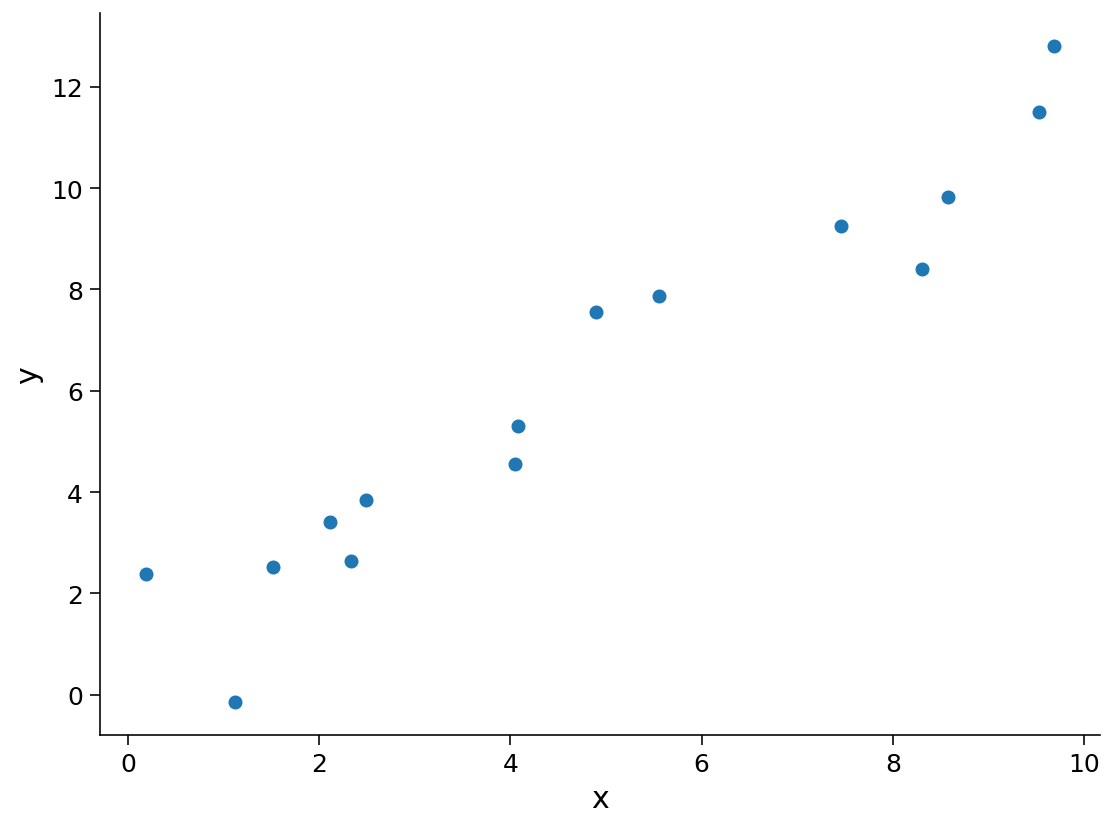

In [3]:
# Simulate some data
np.random.seed(121)

# Set some parameters
theta = 1.2     # this is our true value for theta
n_samples = 15

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

For __bootstrapping__, we randomly sample from the original data with replacement, always obtaining samples of the same size as the original data. Below defines a function for sampling with replacement.

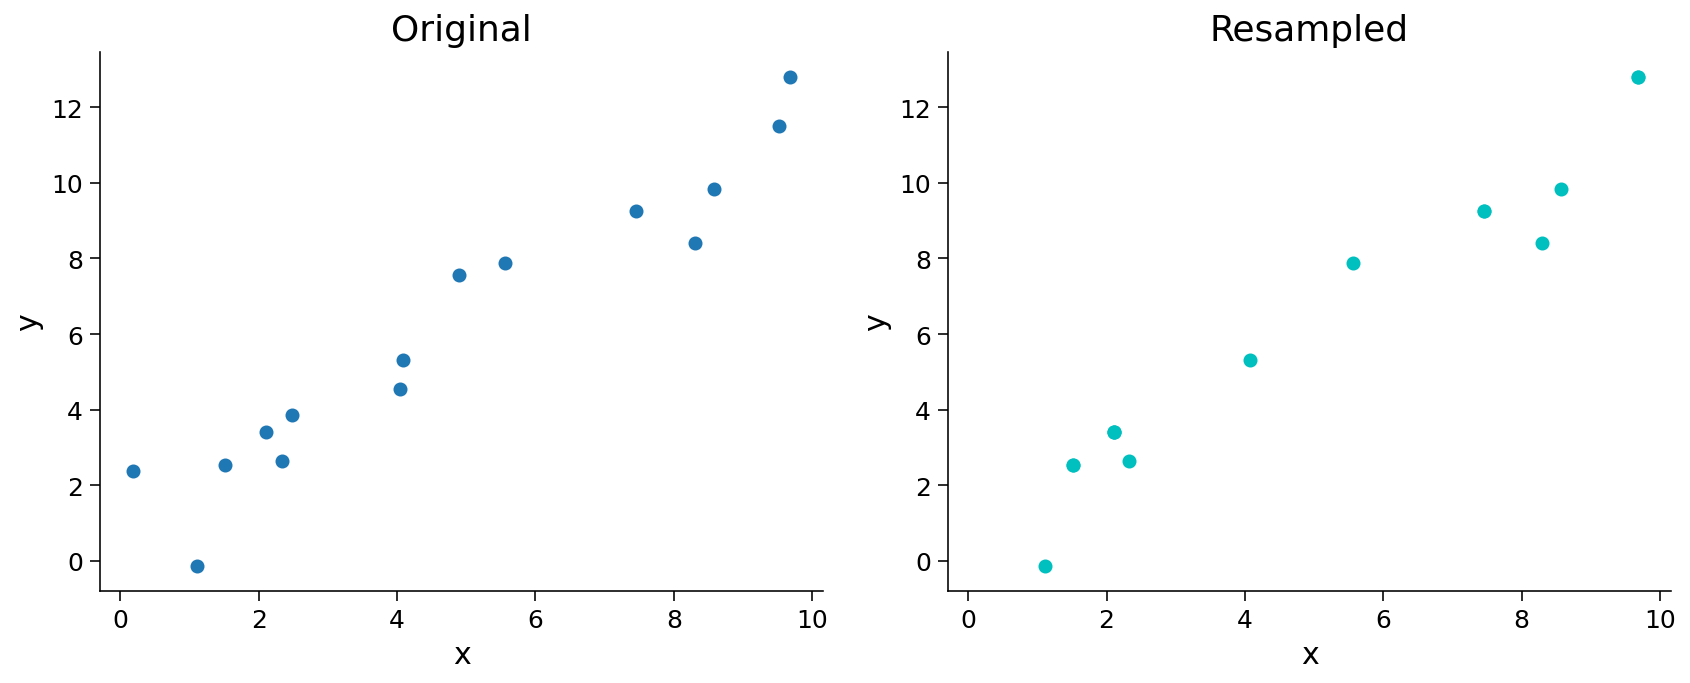

In [4]:
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """

  # Get array of indices for resampled points
  sample_idx = np.random.choice(len(x), size=len(x), replace=True)

  # Sample from x and y according to sample_idx
  x_ = x[sample_idx]
  y_ = y[sample_idx]

  return x_, y_

x_, y_ = resample_with_replacement(x, y)

plot_original_and_resample(x, y, x_, y_)

Finally, for each sample of the original data, we estimate $\theta$ by solving the normal equation (minimizing mean-squared error or maximizing likelihood with Gaussian noise). Below we implement a function for solving the normal equation and another function that finds all estimates of theta for $n$ bootstrapped samples of the original data. Using these functions, we visulize each of the estimates for $\theta$ for 2000 samples of the original data.

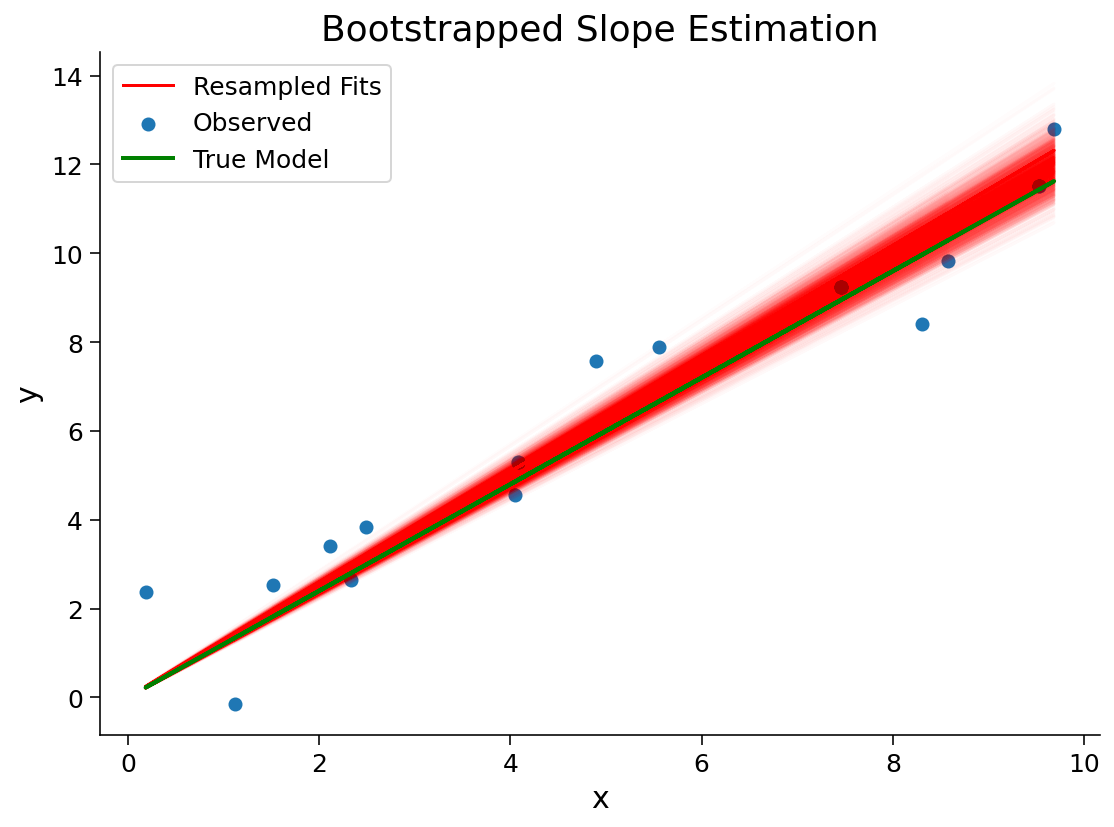

In [8]:
# helper function
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    thata_hat (float): An estimate of the slope parameter.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """
  theta_hat = (x.T @ y) / (x.T @ x)
  return theta_hat

def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute

  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)

  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y)

    # Compute theta_hat for this sample
    theta_hats[i] = solve_normal_eqn(x_, y_)

  return theta_hats


fig, ax = plt.subplots()

# For each theta_hat, plot model
theta_hats = bootstrap_estimates(x, y, n=2000)
for i, theta_hat in enumerate(theta_hats):
  y_hat = theta_hat * x
  ax.plot(x, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i==0 else '')

# Plot observed data
ax.scatter(x, y, label='Observed')

# Plot true fit data
y_true = theta * x
ax.plot(x, y_true, 'g', linewidth=2, label='True Model')

ax.set(
  title='Bootstrapped Slope Estimation',
  xlabel='x',
  ylabel='y'
)

# Change legend line alpha property
handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)

ax.legend();

Finally, using these estimates for $\theta$, we can plot our confidence interval for $\theta$ and compare it with its true value defined at the beginning of the tutorial: $\theta = 1.2$. We see that the true value of $\theta$ is within the 95% confidence interval of our estimate, so we consider our initial estimate for $\theta$ to be a good estimate.

mean = 1.24, std = 0.05


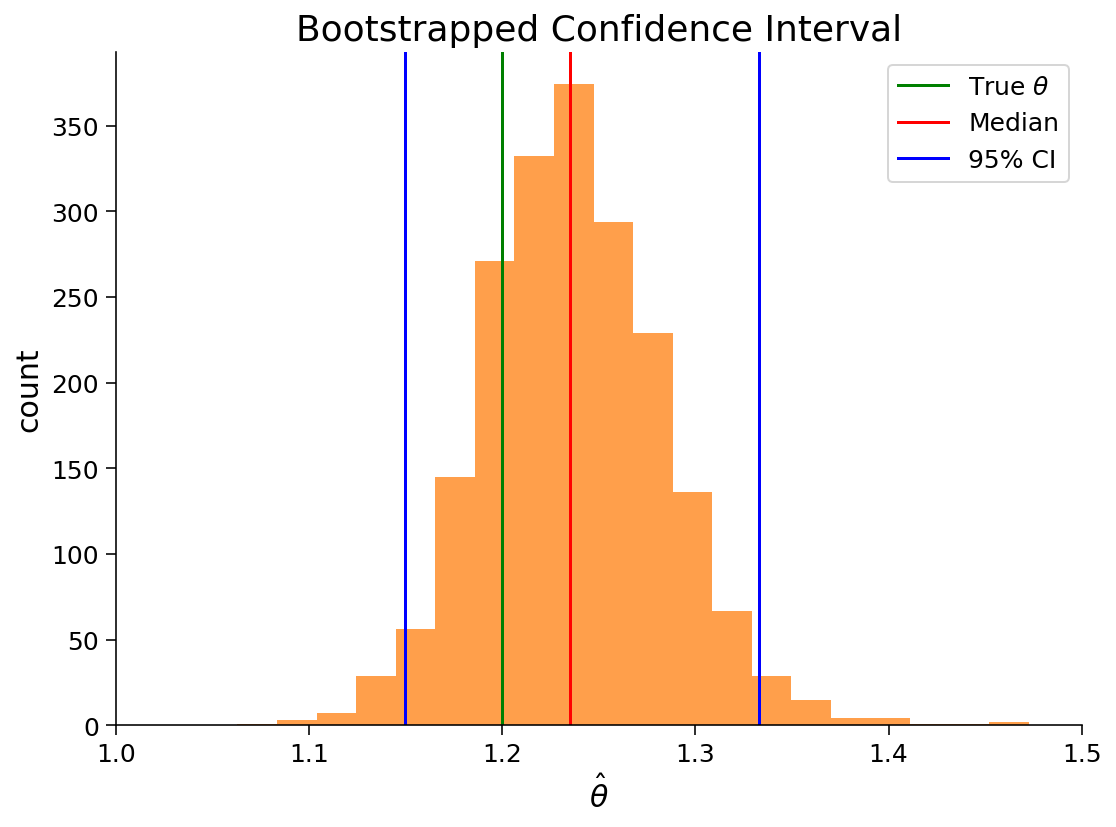

In [7]:
# Plot bootstrapped CI

theta_hats = bootstrap_estimates(x, y, n=2000)
print(f"mean = {np.mean(theta_hats):.2f}, std = {np.std(theta_hats):.2f}")

fig, ax = plt.subplots()
ax.hist(theta_hats, bins=20, facecolor='C1', alpha=0.75)
ax.axvline(theta, c='g', label=r'True $\theta$')
ax.axvline(np.percentile(theta_hats, 50), color='r', label='Median')
ax.axvline(np.percentile(theta_hats, 2.5), color='b', label='95% CI')
ax.axvline(np.percentile(theta_hats, 97.5), color='b')
ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel=r'$\hat{{\theta}}$',
    ylabel='count',
    xlim=[1.0, 1.5]
);